This files creates the training and test datasets for all other notebooks and scripts to reuse. This is the file I would typically use for an exploratory analysis.

In [1]:
import pickle
import time

import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import helpsk as hlp

%matplotlib inline

# Load Data

In [2]:
# https://www.openml.org/d/537
housing_g = fetch_openml('houses', version=1)

housing = housing_g['data']
housing['target'] = housing_g['target']
del housing_g

print(housing.shape)
housing.head()

(20640, 9)


,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude,target
0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23,452600.0
1,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22,358500.0
2,7.2574,52.0,1467.0,190.0,496.0,177.0,37.85,-122.24,352100.0
3,5.6431,52.0,1274.0,235.0,558.0,219.0,37.85,-122.25,341300.0
4,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25,342200.0


In [3]:
## Create Missing Values
housing['median_income'].iloc[0:46] = np.nan
housing['housing_median_age'].iloc[25:75] = np.nan
housing['total_rooms'].iloc[10:54] = 0

In [4]:
hlp.pandas.numeric_summary(housing)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
median_income,"20,594",46,0.0%,0,0.0%,3.9,1.9,0.5,1.6,5.0,0.5,1.9,2.6,3.5,4.8,6.2,15.0
housing_median_age,"20,590",50,0.0%,0,0.0%,28.6,12.6,0.4,0.1,-0.8,1.0,12.0,18.0,29.0,37.0,46.0,52.0
total_rooms,"20,640",0,0.0%,44,0.0%,"2,632.3","2,184.3",0.8,4.1,32.5,0.0,932.0,"1,444.0","2,125.0","3,146.2","4,651.5","39,320.0"
total_bedrooms,"20,640",0,0.0%,0,0.0%,537.9,421.2,0.8,3.5,21.9,1.0,198.0,295.0,435.0,647.0,966.0,"6,445.0"
population,"20,640",0,0.0%,0,0.0%,"1,425.5","1,132.5",0.8,4.9,73.5,3.0,510.0,787.0,"1,166.0","1,725.0","2,566.0","35,682.0"
households,"20,640",0,0.0%,0,0.0%,499.5,382.3,0.8,3.4,22.1,1.0,184.0,280.0,409.0,605.0,890.0,"6,082.0"
latitude,"20,640",0,0.0%,0,0.0%,35.6,2.1,0.1,0.5,-1.1,32.5,33.6,33.9,34.3,37.7,38.5,42.0
longitude,"20,640",0,0.0%,0,0.0%,-119.6,2.0,-0.0,-0.3,-1.3,-124.3,-122.3,-121.8,-118.5,-118.0,-117.2,-114.3
target,"20,640",0,0.0%,0,0.0%,"206,855.8","115,395.6",0.6,1.0,0.3,"14,999.0","82,300.0","119,600.0","179,700.0","264,725.0","376,600.0","500,001.0"


In [5]:
hlp.pandas.non_numeric_summary(housing)

# Training and Test Data

In [6]:
y_full = housing['target']
X_full = housing.drop(columns='target')

del housing

<AxesSubplot:ylabel='Frequency'>

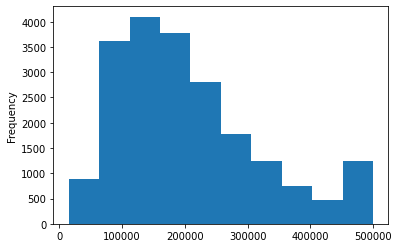

In [7]:
y_full.plot.hist()

In [8]:
y_full[0:10]

0    452600.0
1    358500.0
2    352100.0
3    341300.0
4    342200.0
5    269700.0
6    299200.0
7    241400.0
8    226700.0
9    261100.0
Name: target, dtype: float64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

In [10]:
print(X_train.shape)
print(len(y_train))

print(X_test.shape)
print(len(y_test))

(16512, 8)
16512
(4128, 8)
4128


In [22]:
search_space = hlp.sklearn_search_bayesian.BayesianSearchSpace(
    data=X_train,
    model_type='regression',
    iterations=50,
    random_state=42,
)

In [23]:
# pip install scikit-optimize
from skopt import BayesSearchCV
from sklearn.model_selection import RepeatedKFold


_, X_sample, _, y_sample = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_sample.shape)

bayes_search = BayesSearchCV(
    estimator=search_space.pipeline(),
    search_spaces=search_space.search_spaces(),
    cv=RepeatedKFold(n_splits=5, n_repeats=2, random_state=42),  # 5 fold 2 repeat CV
    #scoring='neg_root_mean_squared_error',
    scoring='neg_mean_absolute_error',
    refit=False,  # required if passing in multiple scorers
    return_train_score=False,
    # n_jobs=-1,
    verbose=2,
    random_state=42,
)

start_time = time.time()
bayes_search.fit(X_sample, y_sample)
elapsed_time = time.time() - start_time

(3303, 8)
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=ElasticNet(random_state=42), model__alpha=3.3117333277546708, model__l1_ratio=0.49646670359671674, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=MinMaxScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=3.3117333277546708, model__l1_ratio=0.49646670359671674, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=MinMaxScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=3.3117333277546708, model__l1_ratio=0.49646670359671674, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=Sim

[CV] END model=ElasticNet(random_state=42), model__alpha=0.8071980758451054, model__l1_ratio=0.7412827443680273, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.8071980758451054, model__l1_ratio=0.7412827443680273, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.8071980758451054, model__l1_ratio=0.7412827443680273, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='m

[CV] END model=ElasticNet(random_state=42), model__alpha=1.1997705954266877e-05, model__l1_ratio=0.8501355739374978, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=1.1997705954266877e-05, model__l1_ratio=0.8501355739374978, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=1.1997705954266877e-05, model__l1_ratio=0.8501355739374978, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer

[CV] END model=ElasticNet(random_state=42), model__alpha=0.06919265725491079, model__l1_ratio=0.3693283263833726, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=ElasticNet(random_state=42), model__alpha=5.600205395082396e-05, model__l1_ratio=0.29076195789909237, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=PCA(n_components='mle'), prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=5.600205395082396e-05, model__l1_ratio=0.29076195789909237, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), p

[CV] END model=ElasticNet(random_state=42), model__alpha=1e-05, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=MinMaxScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=1e-05, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=MinMaxScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=1e-05, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=MinMaxScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=1e-05, model_

[CV] END model=ElasticNet(random_state=42), model__alpha=0.00013540046634210538, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transformer=PCA(n_components='mle'), prep__numeric__scaler__transformer=MinMaxScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.00013540046634210538, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transformer=PCA(n_components='mle'), prep__numeric__scaler__transformer=MinMaxScaler(); total time=   0.0s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=ElasticNet(random_state=42), model__alpha=0.00022734531198765164, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transform

/home/shane/anaconda3/envs/python-examples/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.859e+12, tolerance: 3.704e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/shane/anaconda3/envs/python-examples/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.590e+12, tolerance: 3.576e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitt

[CV] END model=ElasticNet(random_state=42), model__alpha=0.00022734531198765164, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.00022734531198765164, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.00022734531198765164, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END mode

/home/shane/anaconda3/envs/python-examples/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.555e+12, tolerance: 3.686e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/shane/anaconda3/envs/python-examples/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.655e+12, tolerance: 3.638e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitt

[CV] END model=ElasticNet(random_state=42), model__alpha=0.00022734531198765164, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.00022734531198765164, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.00022734531198765164, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s


/home/shane/anaconda3/envs/python-examples/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.625e+12, tolerance: 3.655e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/shane/anaconda3/envs/python-examples/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.616e+12, tolerance: 3.593e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitt

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=ElasticNet(random_state=42), model__alpha=0.00018158669181422843, model__l1_ratio=0.9999999088921915, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.00018158669181422843, model__l1_ratio=0.9999999088921915, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.00018158669181422843, model__l1_ratio=0.9999999088921915, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pc

[CV] END model=ElasticNet(random_state=42), model__alpha=0.0006172771276774438, model__l1_ratio=0.5697713068534882, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.0006172771276774438, model__l1_ratio=0.5697713068534882, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.0006172771276774438, model__l1_ratio=0.5697713068534882, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__num

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=ElasticNet(random_state=42), model__alpha=0.00017929707240099977, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.00017929707240099977, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.00017929707240099977, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric_

[CV] END model=ElasticNet(random_state=42), model__alpha=0.0007031185064883919, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.0007031185064883919, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.0007031185064883919, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transfo

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=ElasticNet(random_state=42), model__alpha=0.00022538701685238775, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.00022538701685238775, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.00022538701685238775, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric_

/home/shane/anaconda3/envs/python-examples/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.859e+12, tolerance: 3.704e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/shane/anaconda3/envs/python-examples/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.590e+12, tolerance: 3.576e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitt

[CV] END model=ElasticNet(random_state=42), model__alpha=0.00022538701685238775, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.00022538701685238775, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.00022538701685238775, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=St

/home/shane/anaconda3/envs/python-examples/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.616e+12, tolerance: 3.593e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(



[CV] END model=ElasticNet(random_state=42), model__alpha=0.00022538701685238775, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=ElasticNet(random_state=42), model__alpha=0.0007146468723325941, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.0007146468723325941, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(s

[CV] END model=ElasticNet(random_state=42), model__alpha=0.0007179807298676247, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.0007179807298676247, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.0007179807298676247, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transfo

[CV] END model=ElasticNet(random_state=42), model__alpha=0.0007208510991366097, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=ElasticNet(random_state=42), model__alpha=0.0002536915879234851, model__l1_ratio=0.5203319445281445, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.0002536915879234851, model__l1_ratio=0.5203319445281445, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer_

[CV] END model=ElasticNet(random_state=42), model__alpha=0.0007237361967418882, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.0007237361967418882, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.0007237361967418882, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transfo

[CV] END model=ElasticNet(random_state=42), model__alpha=0.0007252005727296613, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=ElasticNet(random_state=42), model__alpha=0.0007258809900411252, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.0007258809900411252, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=

[CV] END model=ElasticNet(random_state=42), model__alpha=0.0007758443439747038, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.0007758443439747038, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.0007758443439747038, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transfo

/home/shane/anaconda3/envs/python-examples/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.867e+12, tolerance: 3.704e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/shane/anaconda3/envs/python-examples/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.594e+12, tolerance: 3.576e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitt

[CV] END model=ElasticNet(random_state=42), model__alpha=0.00017547811428498338, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=PCA(n_components='mle'), prep__numeric__scaler__transformer=StandardScaler(); total time=   0.1s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.00017547811428498338, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=PCA(n_components='mle'), prep__numeric__scaler__transformer=StandardScaler(); total time=   0.1s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.00017547811428498338, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=PCA(n_components='mle'), prep__numeric__scaler__trans

/home/shane/anaconda3/envs/python-examples/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.578e+12, tolerance: 3.686e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/shane/anaconda3/envs/python-examples/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.663e+12, tolerance: 3.638e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitt

[CV] END model=ElasticNet(random_state=42), model__alpha=0.00017547811428498338, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=PCA(n_components='mle'), prep__numeric__scaler__transformer=StandardScaler(); total time=   0.1s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.00017547811428498338, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=PCA(n_components='mle'), prep__numeric__scaler__transformer=StandardScaler(); total time=   0.1s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.00017547811428498338, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=PCA(n_components='mle'), prep__numeric__scaler__trans

/home/shane/anaconda3/envs/python-examples/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.637e+12, tolerance: 3.655e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/shane/anaconda3/envs/python-examples/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.635e+12, tolerance: 3.593e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitt

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=ElasticNet(random_state=42), model__alpha=1.9368082655081366e-05, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=1.9368082655081366e-05, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.1s
[CV] END model=ElasticNet(random_state=42), model__alpha=1.9368082655081366e-05, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__t

/home/shane/anaconda3/envs/python-examples/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.852e+12, tolerance: 3.704e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/shane/anaconda3/envs/python-examples/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.584e+12, tolerance: 3.576e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitt

[CV] END model=ElasticNet(random_state=42), model__alpha=1.9368082655081366e-05, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.1s
[CV] END model=ElasticNet(random_state=42), model__alpha=1.9368082655081366e-05, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.1s
[CV] END model=ElasticNet(random_state=42), model__alpha=1.9368082655081366e-05, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.1s
[CV] END mode

/home/shane/anaconda3/envs/python-examples/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.548e+12, tolerance: 3.686e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/shane/anaconda3/envs/python-examples/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.648e+12, tolerance: 3.638e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitt

[CV] END model=ElasticNet(random_state=42), model__alpha=1.9368082655081366e-05, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.1s
[CV] END model=ElasticNet(random_state=42), model__alpha=1.9368082655081366e-05, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.1s
[CV] END model=ElasticNet(random_state=42), model__alpha=1.9368082655081366e-05, model__l1_ratio=0.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.1s


/home/shane/anaconda3/envs/python-examples/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.618e+12, tolerance: 3.655e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/shane/anaconda3/envs/python-examples/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.609e+12, tolerance: 3.593e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitt

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=ElasticNet(random_state=42), model__alpha=0.00045041329063737515, model__l1_ratio=0.923434811289107, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=MinMaxScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.00045041329063737515, model__l1_ratio=0.923434811289107, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=MinMaxScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.00045041329063737515, model__l1_ratio=0.923434811289107, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__tran

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=ElasticNet(random_state=42), model__alpha=0.0004511816268554373, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=PCA(n_components='mle'), prep__numeric__scaler__transformer=MinMaxScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.0004511816268554373, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=PCA(n_components='mle'), prep__numeric__scaler__transformer=MinMaxScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.0004511816268554373, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer

[CV] END model=ElasticNet(random_state=42), model__alpha=0.0007288177875097225, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.0007288177875097225, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.0007288177875097225, model__l1_ratio=1.0, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transfo

[CV] END model=ElasticNet(random_state=42), model__alpha=0.0007247379093259276, model__l1_ratio=0.9961533640899077, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=StandardScaler(); total time=   0.0s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=ElasticNet(random_state=42), model__alpha=0.0004593399150632884, model__l1_ratio=0.9498312315389299, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=PCA(n_components='mle'), prep__numeric__scaler__transformer=MinMaxScaler(); total time=   0.0s
[CV] END model=ElasticNet(random_state=42), model__alpha=0.0004593399150632884, model__l1_ratio=0.9498312315389299, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer_

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=66, model__max_features=0.07544840465806944, model__max_samples=0.5265932728102989, model__min_samples_leaf=10, model__min_samples_split=22, model__n_estimators=1892, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=PCA(n_components='mle'), prep__numeric__scaler__transformer=None; total time=   1.8s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=66, model__max_features=0.07544840465806944, model__max_samples=0.5265932728102989, model__min_samples_leaf=10, model__min_samples_split=22, model__n_estimators=1892, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=PCA(n_compo

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=poisson, model__max_depth=10, model__max_features=0.17594073211649786, model__max_samples=0.7785859384669823, model__min_samples_leaf=38, model__min_samples_split=44, model__n_estimators=1515, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   1.4s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=poisson, model__max_depth=10, model__max_features=0.17594073211649786, model__max_samples=0.7785859384669823, model__min_samples_leaf=38, model__min_samples_split=44, model__n_estimators=1515, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=47, model__max_features=0.8584842529429693, model__max_samples=0.8426731247161765, model__min_samples_leaf=12, model__min_samples_split=7, model__n_estimators=1899, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=PCA(n_components='mle'), prep__numeric__scaler__transformer=None; total time=   2.7s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=47, model__max_features=0.8584842529429693, model__max_samples=0.8426731247161765, model__min_samples_leaf=12, model__min_samples_split=7, model__n_estimators=1899, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=6, model__max_features=0.14325025214201653, model__max_samples=0.8364765069263487, model__min_samples_leaf=10, model__min_samples_split=25, model__n_estimators=645, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   0.6s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=6, model__max_features=0.14325025214201653, model__max_samples=0.8364765069263487, model__min_samples_leaf=10, model__min_samples_split=25, model__n_estimators=645, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='mos

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=poisson, model__max_depth=14, model__max_features=0.9488185721118035, model__max_samples=0.8426341868091698, model__min_samples_leaf=39, model__min_samples_split=27, model__n_estimators=1516, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=PCA(n_components='mle'), prep__numeric__scaler__transformer=None; total time=   2.0s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=poisson, model__max_depth=14, model__max_features=0.9488185721118035, model__max_samples=0.8426341868091698, model__min_samples_leaf=39, model__min_samples_split=27, model__n_estimators=1516, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__tra

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=85, model__max_features=0.4056546314020381, model__max_samples=0.6755127827369526, model__min_samples_leaf=33, model__min_samples_split=47, model__n_estimators=1741, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=PCA(n_components='mle'), prep__numeric__scaler__transformer=None; total time=   1.6s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=85, model__max_features=0.4056546314020381, model__max_samples=0.6755127827369526, model__min_samples_leaf=33, model__min_samples_split=47, model__n_estimators=1741, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numer

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=poisson, model__max_depth=73, model__max_features=0.25327354218460413, model__max_samples=0.6460631045215887, model__min_samples_leaf=30, model__min_samples_split=46, model__n_estimators=1752, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   1.8s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=poisson, model__max_depth=73, model__max_features=0.25327354218460413, model__max_samples=0.6460631045215887, model__min_samples_leaf=30, model__min_samples_split=46, model__n_estimators=1752, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transf

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=57, model__max_features=0.8644703829928809, model__max_samples=0.8076144030149088, model__min_samples_leaf=11, model__min_samples_split=6, model__n_estimators=1856, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=PCA(n_components='mle'), prep__numeric__scaler__transformer=None; total time=   2.6s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=57, model__max_features=0.8644703829928809, model__max_samples=0.8076144030149088, model__min_samples_leaf=11, model__min_samples_split=6, model__n_estimators=1856, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=absolute_error, model__max_depth=1, model__max_features=0.95, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=50, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   5.0s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=absolute_error, model__max_depth=1, model__max_features=0.95, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=50, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transformer=None, prep__nu

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.9420859729898207, model__max_samples=0.5582965820403427, model__min_samples_leaf=1, model__min_samples_split=31, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   2.8s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.9420859729898207, model__max_samples=0.5582965820403427, model__min_samples_leaf=1, model__min_samples_split=31, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='m

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.891637367491805, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=32, model__n_estimators=665, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   1.1s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.891637367491805, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=32, model__n_estimators=665, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8790650172574774, model__max_samples=0.997659557307641, model__min_samples_leaf=1, model__min_samples_split=31, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   0.9s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8790650172574774, model__max_samples=0.997659557307641, model__min_samples_leaf=1, model__min_samples_split=31, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8478050397918564, model__max_samples=0.8960864929525896, model__min_samples_leaf=1, model__min_samples_split=4, model__n_estimators=1119, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   2.7s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8478050397918564, model__max_samples=0.8960864929525896, model__min_samples_leaf=1, model__min_samples_split=4, model__n_estimators=1119, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='mos

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8444468845224935, model__max_samples=0.974445431035126, model__min_samples_leaf=15, model__min_samples_split=2, model__n_estimators=917, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   1.3s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8444468845224935, model__max_samples=0.974445431035126, model__min_samples_leaf=15, model__min_samples_split=2, model__n_estimators=917, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8371291074772812, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   1.5s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8371291074772812, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=15, model__max_features=0.844286160612526, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1996, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   4.8s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=88, model__max_features=0.8410511052900908, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=800, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(st

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=81, model__max_features=0.8370526616671103, model__max_samples=0.7896588932962827, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   5.4s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=81, model__max_features=0.8370526616671103, model__max_samples=0.7896588932962827, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=21, model__max_features=0.8532446027422101, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   1.4s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=86, model__max_features=0.8493121880167074, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=651, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8483842263553848, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1347, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transformer=PCA(n_components='mle'), prep__numeric__scaler__transformer=None; total time=   3.7s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8483842263553848, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1347, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8466913939486146, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   1.5s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.84897807366095, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleI

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8490825703473723, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   1.5s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8490825703473723, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__trans

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8496487200350673, model__max_samples=0.6954866787862536, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   1.3s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8496487200350673, model__max_samples=0.6954866787862536, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8421261111316178, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   5.8s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8421261111316178, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__tra

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8419446069780212, model__max_samples=0.9749986442723825, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1200, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   3.5s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8419446069780212, model__max_samples=0.9749986442723825, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1200, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=No

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8461572054098663, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1581, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   4.6s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=89, model__max_features=0.8631812271565613, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=Simp

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8595299431053472, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   5.9s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8595299431053472, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transforme

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8590710175291282, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   5.9s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8590710175291282, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__tra

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=absolute_error, model__max_depth=100, model__max_features=0.01, model__max_samples=0.5, model__min_samples_leaf=1, model__min_samples_split=50, model__n_estimators=2000, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=  14.2s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=absolute_error, model__max_depth=100, model__max_features=0.01, model__max_samples=0.5, model__min_samples_leaf=1, model__min_samples_split=50, model__n_estimators=2000, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=  14.3s
Fitting 10 folds for e

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8667395224363608, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   5.8s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8667395224363608, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__tra

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=87, model__max_features=0.8536065320739998, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1499, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   4.4s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=87, model__max_features=0.8536065320739998, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1499, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=Simpl

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.848963035622088, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   5.8s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.848963035622088, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__trans

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8478414186570657, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   5.8s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8478414186570657, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__tra

[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8573937709538101, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   5.8s
[CV] END model=ExtraTreesRegressor(bootstrap=True, n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8573937709538101, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__tra

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=poisson, model__max_depth=74, model__max_features=0.13417557229227609, model__max_samples=0.9284887362251846, model__min_samples_leaf=45, model__min_samples_split=49, model__n_estimators=1698, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=PCA(n_components='mle'), prep__numeric__scaler__transformer=None; total time=   4.5s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=poisson, model__max_depth=74, model__max_features=0.13417557229227609, model__max_samples=0.9284887362251846, model__min_samples_leaf=45, model__min_samples_split=49, model__n_estimators=1698, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=PCA(n_components=

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=35, model__max_features=0.8393326218578765, model__max_samples=0.7380830922150186, model__min_samples_leaf=33, model__min_samples_split=28, model__n_estimators=636, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   2.2s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=35, model__max_features=0.8393326218578765, model__max_samples=0.7380830922150186, model__min_samples_leaf=33, model__min_samples_split=28, model__n_estimators=636, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transfor

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=poisson, model__max_depth=94, model__max_features=0.12607161281180967, model__max_samples=0.9259543084806752, model__min_samples_leaf=7, model__min_samples_split=7, model__n_estimators=1006, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transformer=PCA(n_components='mle'), prep__numeric__scaler__transformer=None; total time=   4.7s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=poisson, model__max_depth=94, model__max_features=0.12607161281180967, model__max_samples=0.9259543084806752, model__min_samples_leaf=7, model__min_samples_split=7, model__n_estimators=1006, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transformer=PCA(n_c

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=poisson, model__max_depth=89, model__max_features=0.8235396655310628, model__max_samples=0.686984381611204, model__min_samples_leaf=39, model__min_samples_split=39, model__n_estimators=1163, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=PCA(n_components='mle'), prep__numeric__scaler__transformer=None; total time=   9.2s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=poisson, model__max_depth=89, model__max_features=0.8235396655310628, model__max_samples=0.686984381611204, model__min_samples_leaf=39, model__min_samples_split=39, model__n_estimators=1163, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__t

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=absolute_error, model__max_depth=41, model__max_features=0.22501664335325414, model__max_samples=0.9891323173726281, model__min_samples_leaf=21, model__min_samples_split=43, model__n_estimators=1512, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=  27.8s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=absolute_error, model__max_depth=41, model__max_features=0.22501664335325414, model__max_samples=0.9891323173726281, model__min_samples_leaf=21, model__min_samples_split=43, model__n_estimators=1512, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='most_frequent'), prep__numeric__pca__transformer=None, pr

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=54, model__max_features=0.654814416056185, model__max_samples=0.5454985683878778, model__min_samples_leaf=36, model__min_samples_split=30, model__n_estimators=1082, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=PCA(n_components='mle'), prep__numeric__scaler__transformer=None; total time=   2.5s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=54, model__max_features=0.654814416056185, model__max_samples=0.5454985683878778, model__min_samples_leaf=36, model__min_samples_split=30, model__n_estimators=1082, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=PCA(n_com

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=absolute_error, model__max_depth=1, model__max_features=0.95, model__max_samples=0.5, model__min_samples_leaf=50, model__min_samples_split=2, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=PCA(n_components='mle'), prep__numeric__scaler__transformer=None; total time=   6.7s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=absolute_error, model__max_depth=1, model__max_features=0.95, model__max_samples=0.5, model__min_samples_leaf=50, model__min_samples_split=2, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=PCA(n_components='mle'), prep__numeric__scaler__transformer=None; total

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8535035930418166, model__max_samples=0.8356363493394997, model__min_samples_leaf=33, model__min_samples_split=28, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   7.4s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8535035930418166, model__max_samples=0.8356363493394997, model__min_samples_leaf=33, model__min_samples_split=28, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transform

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8820859886414583, model__max_samples=1.0, model__min_samples_leaf=33, model__min_samples_split=28, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   9.0s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.8820859886414583, model__max_samples=1.0, model__min_samples_leaf=33, model__min_samples_split=28, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__s

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.9302042476785223, model__max_samples=1.0, model__min_samples_leaf=33, model__min_samples_split=28, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   2.3s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.9302042476785223, model__max_samples=1.0, model__min_samples_leaf=33, model__min_samples_split=28, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__sca

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.9358897390890818, model__max_samples=1.0, model__min_samples_leaf=33, model__min_samples_split=28, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   2.3s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.9358897390890818, model__max_samples=1.0, model__min_samples_leaf=33, model__min_samples_split=28, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__sca

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.922636897150343, model__max_samples=1.0, model__min_samples_leaf=30, model__min_samples_split=30, model__n_estimators=1186, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   5.4s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.922636897150343, model__max_samples=1.0, model__min_samples_leaf=30, model__min_samples_split=30, model__n_estimators=1186, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__sca

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=16, model__max_features=0.9149651886407403, model__max_samples=0.9637898155776389, model__min_samples_leaf=24, model__min_samples_split=37, model__n_estimators=1554, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   7.3s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=16, model__max_features=0.9149651886407403, model__max_samples=0.9637898155776389, model__min_samples_leaf=24, model__min_samples_split=37, model__n_estimators=1554, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=56, model__max_features=0.9079420940905638, model__max_samples=1.0, model__min_samples_leaf=18, model__min_samples_split=41, model__n_estimators=958, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   4.8s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=56, model__max_features=0.9079420940905638, model__max_samples=1.0, model__min_samples_leaf=18, model__min_samples_split=41, model__n_estimators=958, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scale

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=90, model__max_features=0.9020670670162392, model__max_samples=1.0, model__min_samples_leaf=15, model__min_samples_split=44, model__n_estimators=883, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   4.5s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=90, model__max_features=0.9020670670162392, model__max_samples=1.0, model__min_samples_leaf=15, model__min_samples_split=44, model__n_estimators=883, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scale

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=89, model__max_features=0.9041276190626827, model__max_samples=1.0, model__min_samples_leaf=15, model__min_samples_split=47, model__n_estimators=870, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   4.4s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=89, model__max_features=0.9041276190626827, model__max_samples=1.0, model__min_samples_leaf=15, model__min_samples_split=47, model__n_estimators=870, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scale

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=43, model__max_features=0.8968066188919432, model__max_samples=1.0, model__min_samples_leaf=14, model__min_samples_split=36, model__n_estimators=1004, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   5.1s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=43, model__max_features=0.8968066188919432, model__max_samples=1.0, model__min_samples_leaf=14, model__min_samples_split=36, model__n_estimators=1004, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__sca

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=45, model__max_features=0.8814895270327274, model__max_samples=1.0, model__min_samples_leaf=12, model__min_samples_split=13, model__n_estimators=1988, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=  10.8s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=45, model__max_features=0.8814895270327274, model__max_samples=1.0, model__min_samples_leaf=12, model__min_samples_split=13, model__n_estimators=1988, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='media

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=89, model__max_features=0.8840896756119663, model__max_samples=1.0, model__min_samples_leaf=11, model__min_samples_split=7, model__n_estimators=1750, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   9.7s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=89, model__max_features=0.8840896756119663, model__max_samples=1.0, model__min_samples_leaf=11, model__min_samples_split=7, model__n_estimators=1750, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scale

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=73, model__max_features=0.9134431443026625, model__max_samples=1.0, model__min_samples_leaf=9, model__min_samples_split=2, model__n_estimators=615, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   3.6s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=73, model__max_features=0.9134431443026625, model__max_samples=1.0, model__min_samples_leaf=9, model__min_samples_split=2, model__n_estimators=615, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__t

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=42, model__max_features=0.9389659498011674, model__max_samples=1.0, model__min_samples_leaf=8, model__min_samples_split=2, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   2.9s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=42, model__max_features=0.9389659498011674, model__max_samples=1.0, model__min_samples_leaf=8, model__min_samples_split=2, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__t

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=46, model__max_features=0.95, model__max_samples=1.0, model__min_samples_leaf=7, model__min_samples_split=2, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   2.9s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=46, model__max_features=0.95, model__max_samples=1.0, model__min_samples_leaf=7, model__min_samples_split=2, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=46, model__max_features=0.95, model__max_samples=0.9739540836634074, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=913, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   7.5s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=46, model__max_features=0.95, model__max_samples=0.9739540836634074, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=913, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler_

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.95, model__max_samples=0.991600173456543, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1293, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=  10.7s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.95, model__max_samples=0.991600173456543, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1293, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scale

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.95, model__max_samples=0.9154180128881464, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=580, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   4.6s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.95, model__max_samples=0.9154180128881464, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=580, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=  

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.95, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1426, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=  11.8s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.95, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1426, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=21, model__max_features=0.95, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1171, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   9.7s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=21, model__max_features=0.95, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1171, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total tim

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.95, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=787, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   6.5s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.95, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=787, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   6.6s
[CV] END model=RandomForestRegressor(n_estimators=500, r

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.95, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   4.2s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=100, model__max_features=0.95, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=500, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   4.1s
[CV] END model=RandomFor

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=8, model__max_features=0.95, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=  10.9s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=8, model__max_features=0.95, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000, prep__non_numeric__encoder__transformer=CustomOrdinalEncoder(), prep__numeric__imputer__transformer=SimpleImputer(strategy='median'), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=  10.9s
Fitting 10 folds for eac

[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=81, model__max_features=0.95, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=  16.7s
[CV] END model=RandomForestRegressor(n_estimators=500, random_state=42), model__criterion=squared_error, model__max_depth=81, model__max_features=0.95, model__max_samples=1.0, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000, prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=  16.5s
[CV] END model=RandomFor

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.7457404716671954, model__colsample_bytree=0.7398599704665515, model__learning_rate=0.09931644013381252, model__max_depth=9, model__min_child_weight=7, model__n_estimators=1016, model__reg_alpha=0.09930951271929885, model__reg_lambda=1.140

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.7457404716671954, model__colsample_bytree=0.7398599704665515, model__learning_rate=0.09931644013381252, model__max_depth=9, model__min_child_weight=7, model__n_estimators=1016, model__reg_alpha=0.09930951271929885, model__reg_lambda=1.140

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.6829223483297344, model__colsample_bytree=0.6016505405957974, model__learning_rate=0.027531694516742332, model__max_depth=6, model__min_child_weight=26, model__n_estimators=1825, model__reg_alpha=0.10736518780300612, model__reg_lambda=2.2

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.8412762992987273, model__colsample_bytree=0.9376807145530166, model__learning_rate=0.09960985859318146, model__max_depth=11, model__min_child_weight=12, model__n_estimators=1657, model__reg_alpha=0.39218302715448866, model__reg_lambda=3.0

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.8843323829693224, model__colsample_bytree=0.5821263744299663, model__learning_rate=0.062258649709538406, model__max_depth=4, model__min_child_weight=2, model__n_estimators=759, model__reg_alpha=0.012972602460355913, model__reg_lambda=3.00

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.8843323829693224, model__colsample_bytree=0.5821263744299663, model__learning_rate=0.062258649709538406, model__max_depth=4, model__min_child_weight=2, model__n_estimators=759, model__reg_alpha=0.012972602460355913, model__reg_lambda=3.00

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.5135657326160469, model__colsample_bytree=0.8028601711668194, model__learning_rate=0.042614586464904874, model__max_depth=8, model__min_child_weight=27, model__n_estimators=622, model__reg_alpha=0.7904470794268812, model__reg_lambda=2.214

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.6285869741668318, model__colsample_bytree=0.5436020706512327, model__learning_rate=0.21593560972409856, model__max_depth=2, model__min_child_weight=13, model__n_estimators=1747, model__reg_alpha=0.00017293285252803457, model__reg_lambda=1

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.6285869741668318, model__colsample_bytree=0.5436020706512327, model__learning_rate=0.21593560972409856, model__max_depth=2, model__min_child_weight=13, model__n_estimators=1747, model__reg_alpha=0.00017293285252803457, model__reg_lambda=1

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.6332939208439317, model__colsample_bytree=0.7912420936028113, model__learning_rate=0.013470833367144006, model__max_depth=2, model__min_child_weight=4, model__n_estimators=986, model__reg_alpha=0.4750881440341733, model__reg_lambda=2.5599

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.8990662735043938, model__colsample_bytree=0.9762982009422299, model__learning_rate=0.02473881705946321, model__max_depth=4, model__min_child_weight=29, model__n_estimators=1340, model__reg_alpha=0.0008065413282779499, model__reg_lambda=2.

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.8990662735043938, model__colsample_bytree=0.9762982009422299, model__learning_rate=0.02473881705946321, model__max_depth=4, model__min_child_weight=29, model__n_estimators=1340, model__reg_alpha=0.0008065413282779499, model__reg_lambda=2.

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.6813131427407295, model__colsample_bytree=0.7317282570335787, model__learning_rate=0.04769190457300931, model__max_depth=16, model__min_child_weight=2, model__n_estimators=1527, model__reg_alpha=0.11520631212601985, model__reg_lambda=2.60

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.6373137623957982, model__colsample_bytree=0.8198271343192374, model__learning_rate=0.04135494093160329, model__max_depth=7, model__min_child_weight=3, model__n_estimators=610, model__reg_alpha=0.0001428822637012226, model__reg_lambda=3.93

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=1.0, model__colsample_bytree=0.5, model__learning_rate=0.055062745297379416, model__max_depth=1, model__min_child_weight=2, model__n_estimators=1827, model__reg_alpha=0.0001, mode

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=1.0, model__colsample_bytree=0.5, model__learning_rate=0.055062745297379416, model__max_depth=1, model__min_child_weight=2, model__n_estimators=1827, model__reg_alpha=0.0001, model__reg_lambda=1.0, model__subsample=0.9201479508712898, prep_

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.5351097920455894, model__colsample_bytree=0.7465943688054144, model__learning_rate=0.04400601546957445, model__max_depth=8, model__min_child_weight=22, model__n_estimators=517, model__reg_alpha=0.3943416217926429, model__reg_lambda=1.7820

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=1.0, model__colsample_bytree=1.0, model__learning_rate=0.29999999999999993, model__max_depth=20, model__min_child_weight=50, model__n_estimators=2000, model__reg_alpha=0.00016336555157573645, model__reg_lambda=4.0, model__subsample=0.5, pre

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=1.0, model__colsample_bytree=1.0, model__learning_rate=0.29999999999999993, model__max_depth=20, model__min_child_weight=50, model__n_estimators=2000, model__reg_alpha=0.00016336555157573645, model__reg_lambda=4.0, model__subsample=0.5, pre

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.5416972755320211, model__colsample_bytree=0.8209699124461399, model__learning_rate=0.10555554092739107, model__max_depth=7, model__min_child_weight=17, model__n_estimators=1451, model__reg_alpha=0.21288900683675294, model__reg_lambda=1.48

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.5, model__colsample_bytree=0.7149651518868021, model__learning_rate=0.05906144764922524, model__max_depth=10, model__min_child_weight=7, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=1.2560159623834466, model__subsample

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.5, model__colsample_bytree=0.7149651518868021, model__learning_rate=0.05906144764922524, model__max_depth=10, model__min_child_weight=7, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=1.2560159623834466, model__subsample

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.5137026920222029, model__colsample_bytree=0.8706878615759794, model__learning_rate=0.029388580022297092, model__max_depth=7, model__min_child_weight=50, model__n_estimators=562, model__reg_alpha=0.6722479194226967, model__reg_lambda=3.752

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.7360126729909267, model__colsample_bytree=0.5, model__learning_rate=0.021427190640828136, model__max_depth=9, model__min_child_weight=1, model__n_estimators=500, model__reg_alpha=0.006084208164999143, model__reg_lambda=1.0, model__subsamp

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=1.0, model__colsample_bytree=0.6144124022745773, model__learning_rate=0.052748855096075256, model__max_depth=9, model__min_child_weight=1, model__n_estimators=500, model__reg_alph

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=1.0, model__colsample_bytree=0.6144124022745773, model__learning_rate=0.052748855096075256, model__max_depth=9, model__min_child_weight=1, model__n_estimators=500, model__reg_alpha=0.000217622426289271, model__reg_lambda=1.1741454173820167,

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=1.0, model__colsample_bytree=0.8815375570306372, model__learning_rate=0.013486972590292072, model__max_depth=8, model__min_child_weight=25, model__n_estimators=2000, model__reg_alpha=0.0001, model__reg_lambda=1.0692765677413787, model__subs

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=1.0, model__colsample_bytree=0.6540537763845663, model__learning_rate=0.10980980709540221, model__max_depth=8, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=0.0001, model__reg_lambda=1.0, model__subsample=0.700510084

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=1.0, model__colsample_bytree=0.6540537763845663, model__learning_rate=0.10980980709540221, model__max_depth=8, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=0.0001, model__reg_lambda=1.0, model__subsample=0.700510084

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=1.0, model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=34, model__n_estimators=2000, model__reg_alpha=0.0001, model__reg_lambda=4.0, model__subsample=0.7177484447046019, prep__non_numeric__e

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=1.0, model__colsample_bytree=0.5, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=4.0, model__subsample=0.7264759627287942, prep__non_numeric__encod

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=1.0, model__colsample_bytree=0.5, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=4.0, model__subsample=0.7264759627287942, prep__non_numeric__encod

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.7768471902475397, model__colsample_bytree=0.5, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=1.3085608670868072, model__subsample=0.739140378569

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=1.0, model__colsample_bytree=0.5, model__learning_rate=0.01, model__max_depth=20, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=4.0, model__subsample=1.0, prep__non_numeric__encoder__transforme

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.8480436060654803, model__colsample_bytree=0.5, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__r

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.8480436060654803, model__colsample_bytree=0.5, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=3.345301354867937, model__subsample=0.7115935589155

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.6462781887447977, model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=9, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=3.275570560061823, model__subsample=0.7761156052217

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.5, model__colsample_bytree=1.0, model__learning_rate=0.29999999999999993, model__max_depth=1, model__min_child_weight=50, model__n_estimators=500, model__reg_alpha=0.0001, model__reg_lambda=1.6330620081255318, model__subsample=0.5, prep__

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.5, model__colsample_bytree=1.0, model__learning_rate=0.29999999999999993, model__max_depth=1, model__min_child_weight=50, model__n_estimators=500, model__reg_alpha=0.0001, model__reg_lambda=1.6330620081255318, model__subsample=0.5, prep__

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.5, model__colsample_bytree=0.7822763603962208, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=1.6181758365966354, model__subsample=0.777871645273

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.5216624873045891, model__colsample_bytree=0.5, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=4.0, model__subsample=0.7814960908562921, prep__non

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.5216624873045891, model__colsample_bytree=0.5, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=4.0, model__subsample=0.7814960908562921, prep__non

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.5, model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=0.7527669356980622, prep__non_numeric__encod

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.9417245076051932, model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=0.7340093649186858, prep__non

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.9900402285134875, model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__r

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.9900402285134875, model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=0.7325702105446039, prep__non

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.7493798606132183, model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=1.8680308130888503, model__subsample=0.733209921861

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.5, model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=3.402116551635867, model__subsample=0.7343239026823041, prep__non_

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.5, model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=3.402116551635867, model__subsample=0.7343239026823041, prep__non_

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.5, model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=0.2430857713105253, model__reg_lambda=2.2820619892197085, model__subsample=0.730607002279

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.6335116158850549, model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=0.7340800982695845, prep__non

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.6335116158850549, model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=0.7340800982695845, prep__non

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.8890451072323693, model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=1.154303397003449, model__subsample=0.7348469549654

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.6089669014094444, model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=0.7289278108944688, prep__non

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.6211923164589757, model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=0.08645688774

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.6211923164589757, model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=8, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=0.08645688774194972, model__reg_lambda=1.0, model__subsample=0.76618966882

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.6920166580636483, model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=12, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=0.941176801648326, prep__non

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.999733081079127, model__colsample_bytree=0.8365981261765059, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=0.7479208389881

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.999733081079127, model__colsample_bytree=0.8365981261765059, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=0.7479208389881

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.5, model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=9, model__min_child_weight=1, model__n_estimators=1179, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=0.7350968282602891, prep__non_numeric__encod

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=1.0, model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=4, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=1.0, prep__non_numeric__encoder__transformer

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=1.0, model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=4, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=1.0, prep__non_numeric__encoder__transformer

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=1.0, model__colsample_bytree=0.5, model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=1.6954133809239391, model__subsample=0.7956941219960644, prep__non

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=0.5, model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=20, model__min_child_weight=1, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=1.0, prep__non_numeric__encoder__transformer

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=1.0, model__colsample_bytree=0.5, model__learning_rate=0.01, model__max_depth=20, model__min_child_weight=1, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=1.0, 

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=1.0, model__colsample_bytree=0.5, model__learning_rate=0.01, model__max_depth=20, model__min_child_weight=1, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=0.7886912847498433, prep__non_numeric__encod

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=1.0, model__colsample_bytree=1.0, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=1, model__n_estimators=500, model__reg_alpha=1.0, model__reg_lambda=2.226396204524427, model__subsample=0.7665240870029525, prep__non_n

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=1.0, model__colsample_bytree=0.8045289446296585, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=2.734768672363453, model__subsample=0.7718150404165

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=1.0, model__colsample_bytree=0.8045289446296585, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=2.734768672363453, model__subsample=0.7718150404165

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=1.0, model__colsample_bytree=0.8020018579867875, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=1.0, model__subsample=0.7670094874027291, prep__non

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=1.0, model__colsample_bytree=0.8082936605847955, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=1.09302998202382, model__subsample=0.77740830771048

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), model__colsample_bylevel=1.0, model__colsample_bytree=0.8082936605847955, model__learning_rate=0.01, model__max_depth=7, model__min_child_weight=1, model__n_estimators=2000, model__reg_alpha=1.0, model__reg_lambda=1.09302998202382, model__subsample=0.77740830771048

[CV] END model=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None), prep__non_numeric__encoder__transformer=OneHotEncoder(handle_unknown='ignore'), prep__numeric__imputer__transformer=SimpleImputer(), prep__numeric__pca__transformer=None, prep__numeric__scaler__transformer=None; total time=   0.8s
[CV] END model=XGBRegressor(base_s

In [24]:
print(f"Elapsed time to run BayesSearchCV: {elapsed_time:.3f} seconds; {elapsed_time / 60:.1f} minutes")

Elapsed time to run BayesSearchCV: 7786.640 seconds; 129.8 minutes


In [25]:
print(bayes_search.best_score_)

-35935.17027482089


In [26]:
print(bayes_search.best_params_)

OrderedDict([('model', XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             use_label_encoder=False, validate_parameters=None, verbosity=None)), ('model__colsample_bylevel', 1.0), ('model__colsample_bytree', 0.8020018579867875), ('model__learning_rate', 0.01), ('model__max_depth', 7), ('model__min_child_weight', 1), ('model__n_estimators', 2000), ('model__reg_alpha', 1.0), ('model__reg_lambda', 1.0

In [27]:
results = hlp.sklearn_eval.MLExperimentResults.from_sklearn_search_cv(
    searcher=bayes_search,
    higher_score_is_better=False,
    description='BayesSearchCV using Regression Search Space',
    parameter_name_mappings=search_space.param_name_mappings()
)

In [32]:
results.to_yaml_file(yaml_file_name = 'regression - BayesSearchCV.yaml')

In [33]:
results = hlp.sklearn_eval.MLExperimentResults.from_yaml_file(yaml_file_name = 'regression - BayesSearchCV.yaml')

In [34]:
results.best_score

-35935.17027482089

In [35]:
results.best_params

{'model': 'XGBRegressor()',
 'max_depth': 7,
 'n_estimators': 2000,
 'learning_rate': 0.01,
 'min_child_weight': 1,
 'subsample': 0.7670094874027291,
 'colsample_bytree': 0.8020018579867875,
 'colsample_bylevel': 1.0,
 'reg_alpha': 1.0,
 'reg_lambda': 1.0,
 'imputer': "SimpleImputer(strategy='median')",
 'scaler': 'None',
 'pca': 'None',
 'encoder': 'OneHotEncoder()'}

In [30]:
results.to_formatted_dataframe(return_style=True,
                               include_rank=True,
                               num_rows=1000)

rank,neg_mean_absolute_error Mean,neg_mean_absolute_error 95CI.LO,neg_mean_absolute_error 95CI.HI,model,alpha,l1_ratio,max_features,max_depth,n_estimators,min_samples_split,min_samples_leaf,max_samples,criterion,learning_rate,min_child_weight,subsample,colsample_bytree,colsample_bylevel,reg_alpha,reg_lambda,imputer,scaler,pca,encoder
1,"-35,935.170","-36,595.230","-35,275.111",XGBRegressor(),<NA>,<NA>,<NA>,7.000,"2,000.000",<NA>,<NA>,<NA>,<NA>,0.010,1.000,0.767,0.802,1.000,1.000,1.000,SimpleImputer(strategy='median'),None,None,OneHotEncoder()
2,"-35,989.168","-36,600.993","-35,377.344",XGBRegressor(),<NA>,<NA>,<NA>,7.000,"2,000.000",<NA>,<NA>,<NA>,<NA>,0.010,1.000,0.772,0.805,1.000,1.000,2.735,SimpleImputer(),None,None,OneHotEncoder()
3,"-35,989.804","-36,646.910","-35,332.699",XGBRegressor(),<NA>,<NA>,<NA>,7.000,"2,000.000",<NA>,<NA>,<NA>,<NA>,0.010,1.000,0.748,0.837,1.000,1.000,1.000,SimpleImputer(strategy='median'),None,None,OneHotEncoder()
4,"-35,998.689","-36,631.863","-35,365.516",XGBRegressor(),<NA>,<NA>,<NA>,7.000,"2,000.000",<NA>,<NA>,<NA>,<NA>,0.010,1.000,0.777,0.808,1.000,1.000,1.093,SimpleImputer(),None,None,OneHotEncoder()
5,"-36,189.610","-36,888.244","-35,490.976",XGBRegressor(),<NA>,<NA>,<NA>,7.000,"2,000.000",<NA>,<NA>,<NA>,<NA>,0.010,1.000,0.734,1.000,0.634,1.000,1.000,SimpleImputer(strategy='most_frequent'),None,None,OneHotEncoder()
6,"-36,194.346","-36,929.147","-35,459.546",XGBRegressor(),<NA>,<NA>,<NA>,7.000,"2,000.000",<NA>,<NA>,<NA>,<NA>,0.010,1.000,0.733,1.000,0.749,1.000,1.868,SimpleImputer(strategy='most_frequent'),None,None,OneHotEncoder()
7,"-36,238.577","-36,996.698","-35,480.456",XGBRegressor(),<NA>,<NA>,<NA>,7.000,"2,000.000",<NA>,<NA>,<NA>,<NA>,0.010,1.000,0.753,1.000,0.500,1.000,1.000,SimpleImputer(),None,None,CustomOrdinalEncoder()
8,"-36,249.531","-37,051.552","-35,447.510",XGBRegressor(),<NA>,<NA>,<NA>,8.000,"2,000.000",<NA>,<NA>,<NA>,<NA>,0.010,1.000,0.766,1.000,0.621,0.086,1.000,SimpleImputer(strategy='most_frequent'),None,None,OneHotEncoder()
9,"-36,281.715","-36,984.182","-35,579.248",XGBRegressor(),<NA>,<NA>,<NA>,7.000,"2,000.000",<NA>,<NA>,<NA>,<NA>,0.010,1.000,0.729,1.000,0.609,1.000,1.000,SimpleImputer(strategy='most_frequent'),None,None,CustomOrdinalEncoder()
10,"-36,295.470","-37,038.652","-35,552.289",XGBRegressor(),<NA>,<NA>,<NA>,7.000,"2,000.000",<NA>,<NA>,<NA>,<NA>,0.010,1.000,0.734,1.000,0.942,1.000,1.000,SimpleImputer(strategy='most_frequent'),None,None,OneHotEncoder()
